In [49]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from tqdm import tqdm

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder


In [26]:
from miniai.utils import set_seed, clean_ipython_hist, clean_tb, clean_mem
from miniai.datasets import DataLoaders, inplace
from miniai.conv import conv

from miniai.learner import MomentumLearner, DeviceCB, MetricsCB, ProgressCB, LRFinderCB, TrainLearner, TrainCB, Learner
from miniai.activations import ActivationStats
from miniai.init import GeneralRelu, init_weights, get_model
from miniai.sgd import RecorderCB, BatchSchedCB

from miniai.resnet import act_gr, ResBlock

In [27]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

# Load the dataset

In [28]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [29]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [30]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [31]:
from diffusers import UNet2DModel

In [32]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [57]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps = n_steps
        self.beta_min = beta_min
        self.beta_max = beta_max
        # variance schedule, linearly increased with timestep
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()
    
    def predict(self, learn): 
        learn.preds = learn.model(*learn.batch[0]).sample
     
    def before_batch(self, learn):
        device = learn.batch[0].device
        eps = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.alpha_bar = self.alpha_bar.to(device)
        n = x0.shape[0]
        
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1, 1, 1).to(device)
        xt = alpha_bar_t.sqrt()*x0 + (1-alpha_bar_t).sqrt()*eps #noisify the image
        
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), eps)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in tqdm(reversed(range(self.n_steps))):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            alpha_bar_t1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1)
            beta_bar_t = 1 - self.alpha_bar[t]
            beta_bar_t1 = 1 - alpha_bar_t1
            noise_pred = learn.model(x_t, t_batch).sample
            
            x_0_hat = ((x_t - beta_bar_t.sqrt() * noise_pred)/self.alpha_bar[t].sqrt()).clamp(-1,1)
            x0_coeff = alpha_bar_t1.sqrt()*(1-self.alpha[t])/beta_bar_t
            xt_coeff = self.alpha[t].sqrt()*beta_bar_t1/beta_bar_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.sigma[t]*z
            preds.append(x_t.cpu())
        return preds

In [60]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.055,0,train
0.024,0,eval
0.022,1,train
0.020,1,eval
0.018,2,train
0.017,2,eval
0.017,3,train
0.016,3,eval
0.016,4,train
0.015,4,eval


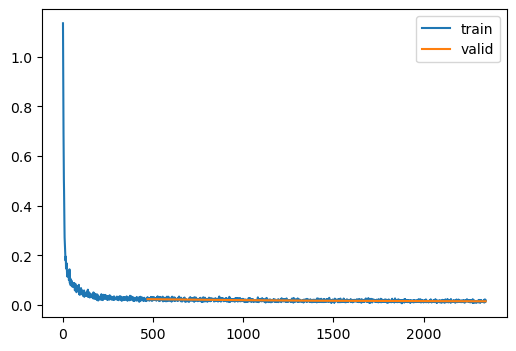

In [44]:
learn.fit(epochs)

In [45]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [46]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [61]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

# Inference

In [62]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000it [01:34, 10.55it/s]


1000

In [67]:
from miniai.plotting import show_images, show_image

In [68]:
show_images(-samples[-1], figsize=(5,5))

In [69]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: MacOSX


RuntimeError: Requested MovieWriter (ffmpeg) not available